# Louvain Community Detection

Community  detection  is  a  critical  component  in  the  anal-isys  of  real-world  network  systems  with  important  appli-cations  in  social  media  analytics,  biology,  recommendationsystems, and telecommunications among others [1]. The Lou-vain  method  [2]  based  on  modularity  optimization  [3]  is  acommonly adopted technique to identify communities.

https://users.ece.cmu.edu/~lowt/papers/Louvain_accepted.pdf

First import and define some utility functions for benchmarking the louvain method:

In [1]:
import random
from random import choice
from time import time

from pygraphblas import *
from pygraphblas import lib
from pygraphblas.gviz import draw

from collections import defaultdict
from itertools import groupby
from operator import itemgetter

def group_labels(T):
    d = defaultdict(list)
    for k,v in groupby(T, itemgetter(1)):
        d[k].append(list(v)[0][0])
    return d

def compare_groups(left, right):
    left = {k: set(v) for k, v in left.items()}
    right = {k: set(v) for k, v in right.items()}
    return sorted(left.values()) == sorted(right.values())

def get_louvain_cluster_assignments(cluster_matrix):
    return cluster_matrix.cast(INT64).apply(INT64.POSITIONJ).reduce_vector()


Define a Matrix to be used for quick testing.  It creates two communities that the algorithm should detect:

In [2]:
I = [0, 0, 0, 0,
    1, 1, 1, 1,
    2, 2, 2, 2,
    3, 3, 3, 3,
    4, 4, 4, 4,
    5, 5, 5, 5, 5,
    6, 6, 6,
    7, 7, 7, 7]

J = [0, 2, 3, 6,
    1, 2, 3, 7,
    0, 2, 4, 6,
    0, 1, 3, 5,
    0, 2, 4, 6,
    1, 3, 5, 6, 7,
    0, 4, 6,
    1, 3, 5, 7]

M = Matrix.from_lists(I, J, [1.0] * len(I), typ=FP64)

Current  implementations  of  the  Louvain  method  adopt  atraditional  vertex-based  approach  in  their  algorithmic  for-mulation  despite  there  being  a  linear  algebraic  formulationfor  the  computation  of  modularity  [4].  In  this  paper,  weshow  that  by  starting  with  the  linear  algebraic  formulationof  modularity,  a  linear  algebraic  algorithm  for  computingthe  Louvain  method  can  be  determined.  This  formulationcan  leverage  recent  community-driven  efforts  behind  linearalgebraic  graph  interfaces,  such  as  the  GraphBLAS  [5],  torapidly  develop  an  implementation  of  the  Louvain  method.Productivity  is  enhanced  through  the  use  of  pygraphblas  [6],a python interface for the GraphBLAS effort

In [3]:
def louvain_cluster_easy(A, max_iters=10):
    S = Matrix.identity(BOOL, A.nrows)
    empty = Vector.sparse(BOOL, A.nrows)
    i = 0
    changed = True
    
    start = time()
    G = A.T + A
    k = A.reduce_vector()
    m = k.reduce_int() / 2.0
    k = (-k) / m
    while changed and i < max_iters:
        changed = False
        for j in set(k.indexes):
            Sj = S[j]
            S[j] = empty
            v = G[j] + k[j]
            q = v @ S
            t = q.select('max')
            if t:
                r = choice(list(t.indexes))
                S[j, r] = True
                if Sj.get(r) is None:
                    changed = True
        i += 1
    return S, time() - start

In [8]:
def louvain_cluster(A, max_iters=10):
    An = A.nrows
    S = Matrix.identity(BOOL, An)
    empty = Vector.sparse(BOOL, An)
    Sj = Vector.sparse(BOOL, An)
    v = Vector.sparse(FP64, An)
    q = Vector.sparse(FP64, An)
    t = Vector.sparse(FP64, An)
    i = 0
    changed = True
    
    start = time()
    G = A.T + A
    k = A.reduce()
    m = k.reduce_int() / 2.0
    k = (-k) / m
    kI = set(k.I)
    while changed and i < max_iters:
        changed = False
        for j in kI:
            S.extract_row(j, out=Sj)                  # Sj = S[j]
            S.assign_row(j, empty)                    # S[j] = empty
            G.extract_row(j, out=v)                   # v = G[j] + nkm[j]
            v.apply_second(FP64.PLUS, k[j], out=v)
            v.vxm(S, out=q)                           # q = v @ S
            if not q:
                continue
            q.select('max', out=t)                    # t = q.select('max')
            if t:
                r = choice(list(t.indexes))
                S[j, r] = True
                if Sj.get(r) is None:
                    changed = True
        i += 1
    return S, time() - start

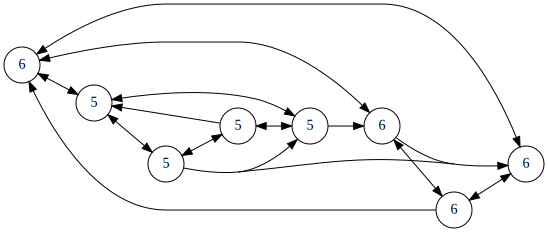

In [9]:
ans, took = louvain_cluster(M, 5)
random.seed(33)
labels = get_louvain_cluster_assignments(ans)
draw(M.offdiag(), show_weight=False, label_vector=labels)

Run the algorithm on the GraphChallenge.org 2017 community detection challenge data set:

http://graphchallenge.mit.edu/data-sets#PartitionDatasets

In [6]:
def py_bench(sizes):
    random.seed(46)
    times = []
    for iters, size in sizes:
        data = Matrix.from_tsv('louvain_data/simulated_blockmodel_graph_%s_nodes.tsv' % size, FP64, size, size)
        print('Loaded', size, 'nodes.')
        ans, took = louvain_cluster(data, max_iters=iters)
        assignments = get_louvain_cluster_assignments(ans)
        with open('louvain_data/simulated_blockmodel_graph_%s_nodes_truePartition.tsv' % size) as truth:
            T = Vector.sparse(UINT8, size)
            for line in truth:
                i, j = map(int, line.split('\t'))
                T[i-1] = j
        times.append(took)
        print(size, f'Took {took:.4} Correct?', compare_groups(group_labels(assignments), group_labels(T)))
    return times

Below is the same algorithm with networkx authored by:
    
https://python-louvain.readthedocs.io/en/latest/

In [7]:
import community
import networkx as nx
from time import time

name = lambda v: "louvain_data/simulated_blockmodel_graph_{}_nodes".format(v)

def make_dict(tup):
    trued = {}
    for n,c in tup:
        trued.setdefault(c, []).append(n)
    trued = { tuple(trued[c]):c for c in trued }
    return trued

def get_nodes_comm(name):
    with open(name + "_truePartition.tsv", "r") as f:
        truep = [tuple(map(int, l.split('\t'))) for l in f]

    G = nx.read_edgelist(name + ".tsv", delimiter='\t', data=(('weight', float),), create_using=nx.DiGraph())
    start = time()
    partition = community.best_partition(G.to_undirected())
    took = time() - start
    print(name, f'took {took}')
    pl = [ (int(n), c) for n,c in list(partition.items()) ]
    pl.sort()
    return make_dict(truep), make_dict(pl), took

ModuleNotFoundError: No module named 'community'

In [ ]:

def nx_bench(sizes):
    nxtimes = []
    for _, numv in sizes:
        trued, pd, took = get_nodes_comm(name(numv))
        nxtimes.append(took)
    return nxtimes


In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


sizes = [(3, 5000), (3, 20000)]#, (3, 50000)]#, (3, 20000), (3, 50000)]

#options_set(nthreads=1)

pytimes = py_bench(sizes)
nxtimes = nx_bench(sizes)

labels = [str(s) for i, s in sizes]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, pytimes, width, label='pygraphblas')
rects2 = ax.bar(x + width/2, nxtimes, width, label='NetworkX')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()
